In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob

In [2]:
def annotate_tool(filename: str) -> str:
    if "bedops" in filename:
        return "bedops"
    if "bedtools" in filename:
        return "bedtools"
    else:
        return "gia"
    
def annotate_function(filename: str) -> str:
    if "bam" in filename:
        return "bam " + filename\
        .split("_")[1]
    else:
        return filename\
            .split("_")[0]

def annotate_mt(filename: str) -> bool:
    return "mt" in filename

def read_result(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    basename = filename.split("/")[-1].split('.')[0]
    df["filename"] = basename
    df["stranded"] = df["filename"].str.contains("stranded")
    df["streamed"] = df["filename"].str.contains("stream")
    df["multithreaded"] = annotate_mt(basename)
    df["tool"] = annotate_tool(basename)
    df["function"] = annotate_function(basename)
    return df

hue_order = ["gia", "bedtools", "bedops"]
hue_colors = {
    "gia": "#1A4D2E",
    "gia_mt": "#4F6F52",
    "gia stranded": "#4F6F52",
    "bedtools": "#F4A460",
    "bedtools stranded": "#F7B787", 
    "bedops": "#FF6347",
}
results_dir = "../results"
frame = pd.concat([read_result(f) for f in glob(f"{results_dir}/*.csv")])
frame

,command,mean,stddev,median,user,system,min,max,filename,stranded,streamed,multithreaded,tool,function
0,bedtools cluster -i data/large.bed > /dev/null,3.582060,0.040048,3.588610,3.437847,0.034419,3.504301,3.654857,cluster_bedtools,False,False,False,bedtools,cluster
0,gia closest -a data/a.stranded.bed -b data/b.s...,1.092727,0.011696,1.087845,1.011837,0.054075,1.079577,1.112029,closest_gia_stranded,True,False,False,gia,closest
0,gia random -n 1000 -g data/genome.txt > /dev/null,0.003546,0.000195,0.003544,0.001921,0.001054,0.003026,0.004679,random_gia_1000,False,False,False,gia,random
0,bedtools intersect -a data/a.sorted.bed -b dat...,1.447621,0.010275,1.448799,1.371185,0.032238,1.423372,1.457374,intersect_stream_bedtools,False,True,False,bedtools,intersect
0,bedtools spacing -i data/large.bed > /dev/null,2.881541,0.022163,2.883668,2.767879,0.030122,2.841542,2.911557,spacing_bedtools,False,False,False,bedtools,spacing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,gia random -n 1000000 -g data/genome.txt > /de...,0.122602,0.000771,0.122562,0.115777,0.003484,0.120790,0.123760,random_gia_1000000,False,False,False,gia,random
0,bedtools closest -a data/a.sorted.bed -b data/...,2.238179,0.014259,2.237765,2.138464,0.040723,2.217895,2.267887,closest_bedtools,False,False,False,bedtools,closest
0,gia coverage -a data/a.sorted.bed -b data/b.so...,0.564537,0.002852,0.565288,0.519176,0.028035,0.556776,0.566537,coverage_gia,False,False,False,gia,coverage
0,bedtools flank -i data/large.bed -g data/genom...,5.233733,0.034123,5.233183,5.039699,0.037859,5.187313,5.305264,flank_bedtools,False,False,False,bedtools,flank


# Base Functions

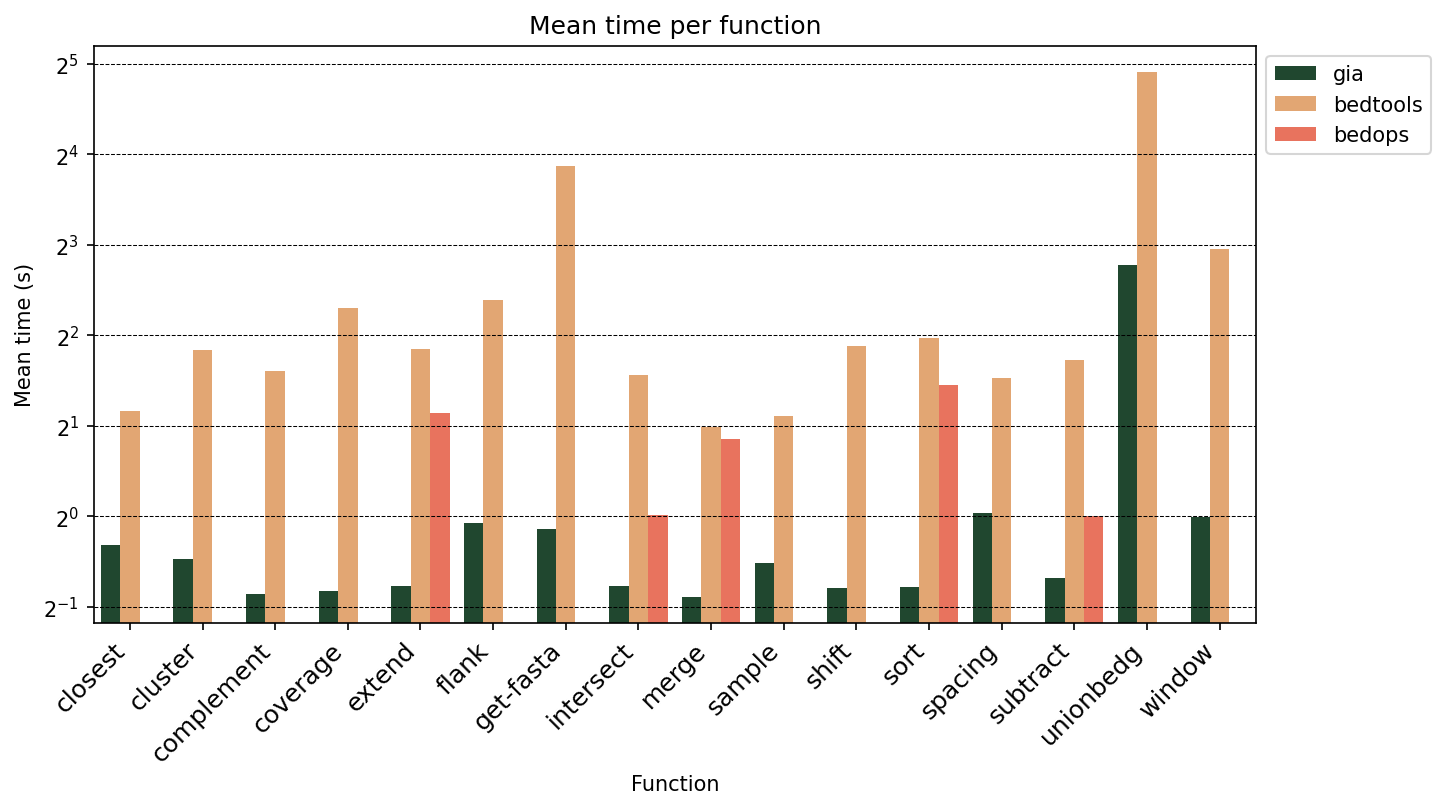

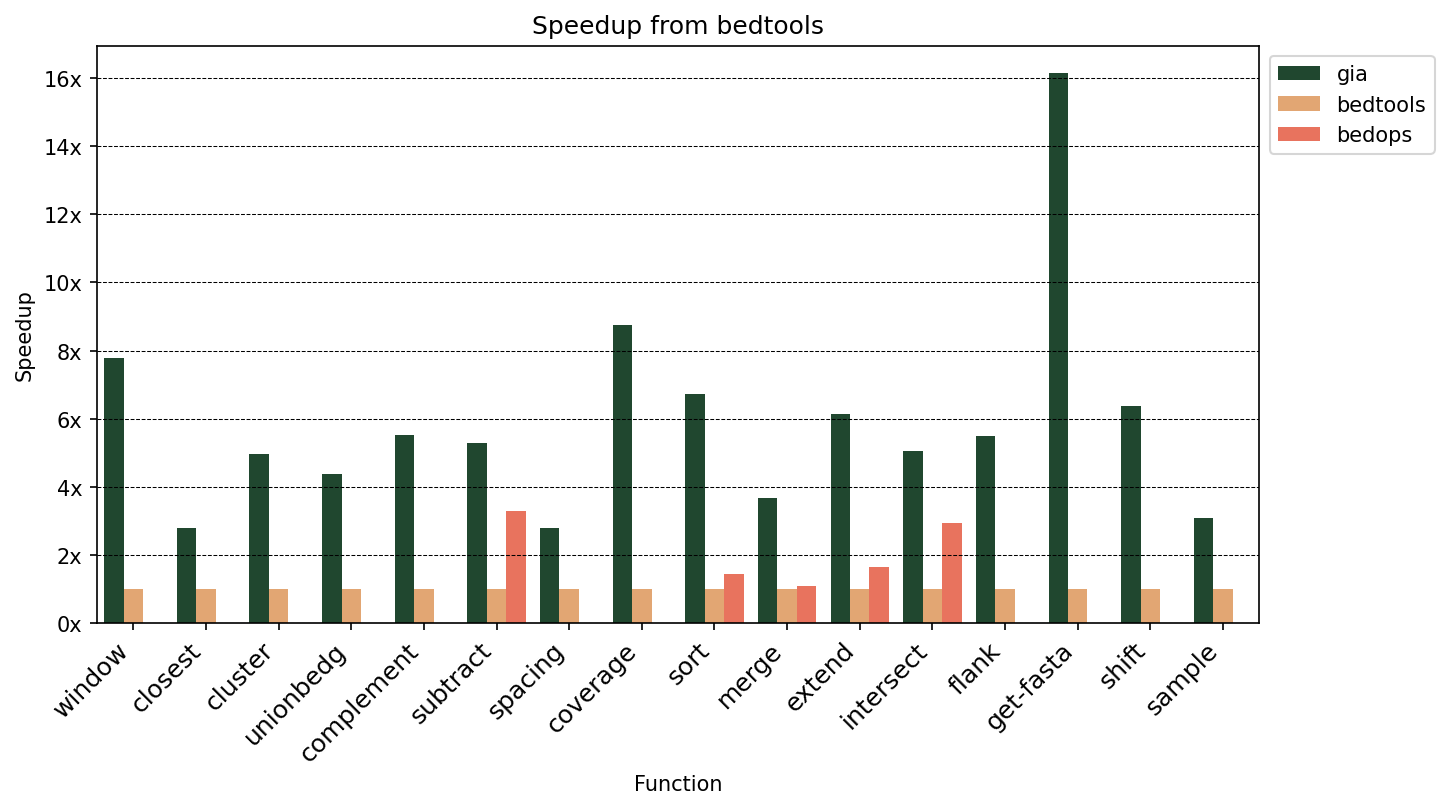

In [3]:
base = frame[
    ~frame["stranded"] &
    (~frame["streamed"] | frame["tool"].eq("bedops")) &
    frame["function"].ne("random") &
    (~frame["function"].str.contains("bam")) &
    (~frame["command"].str.contains("gz"))
].sort_values("function")

# Plots the mean time per function
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot(
    data=base,
    x="function",
    y="mean",
    hue="tool",
    hue_order=hue_order,
    palette=hue_colors,
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Mean time (s)")
plt.xlabel("Function")
plt.title("Mean time per function")
plt.yscale("log", base=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# shows grid on y axis
plt.grid(axis='y', linestyle='--', linewidth=0.5, color="black")
plt.show()

# Calculates the speedup from bedtools
base_speed = base \
    [base["tool"].eq("bedtools")] \
    .groupby("function") \
    .agg({"mean": "first"}) \
    .rename(columns={"mean": "base_time"}) \
    .reset_index()
base_speed = base.merge(base_speed, on="function", how="left") \
    .assign(speedup=lambda x: x["base_time"] / x["mean"]) \
    .sort_values("speedup")

# Plots the speedup from bedtools
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot(
    data=base_speed,
    x="function",
    y="speedup",
    hue="tool",
    hue_order=hue_order,
    palette=hue_colors,
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}x"))
plt.ylabel("Speedup")
plt.xlabel("Function")
plt.title("Speedup from bedtools")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# shows grid on y axis
plt.grid(axis='y', linestyle='--', linewidth=0.5, color="black")
plt.show()


# Bam Specific Functions

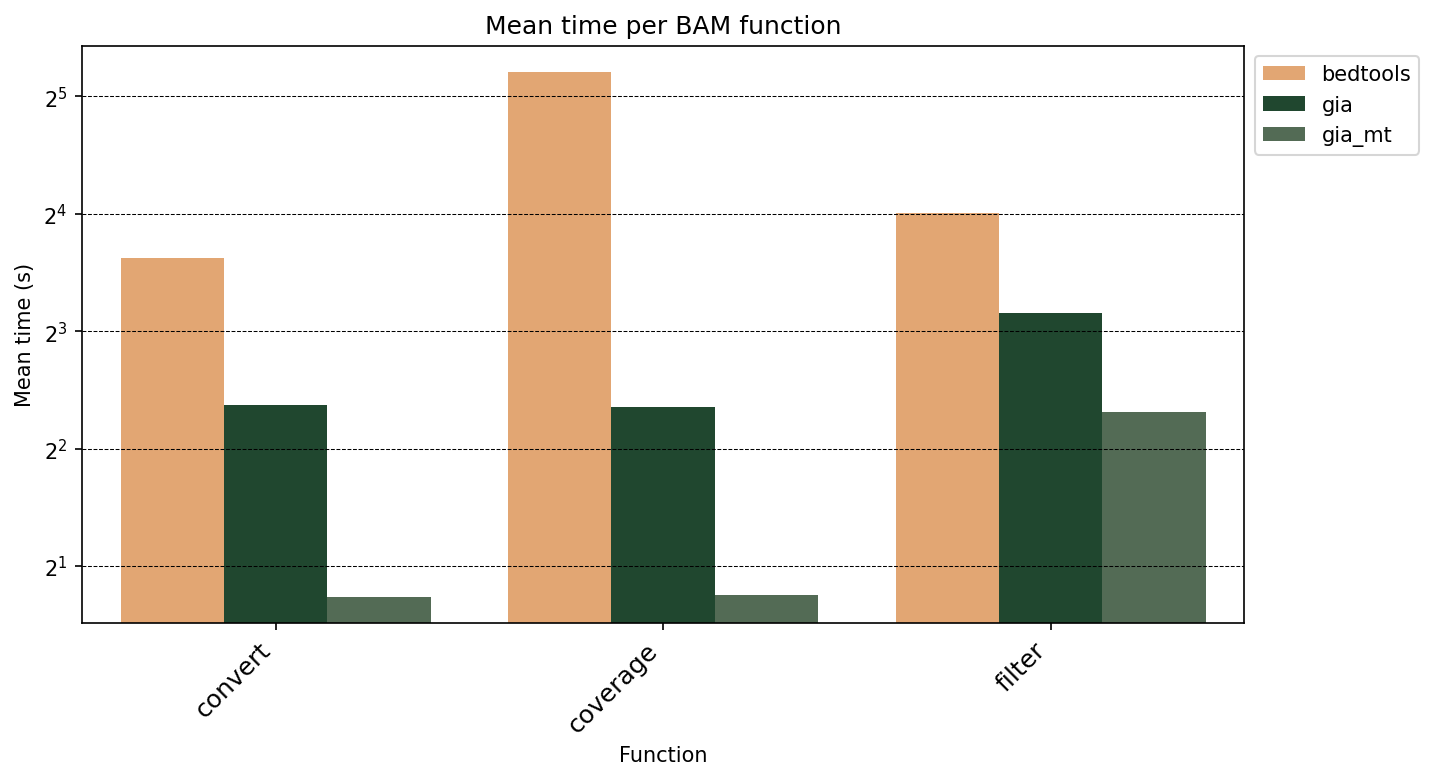

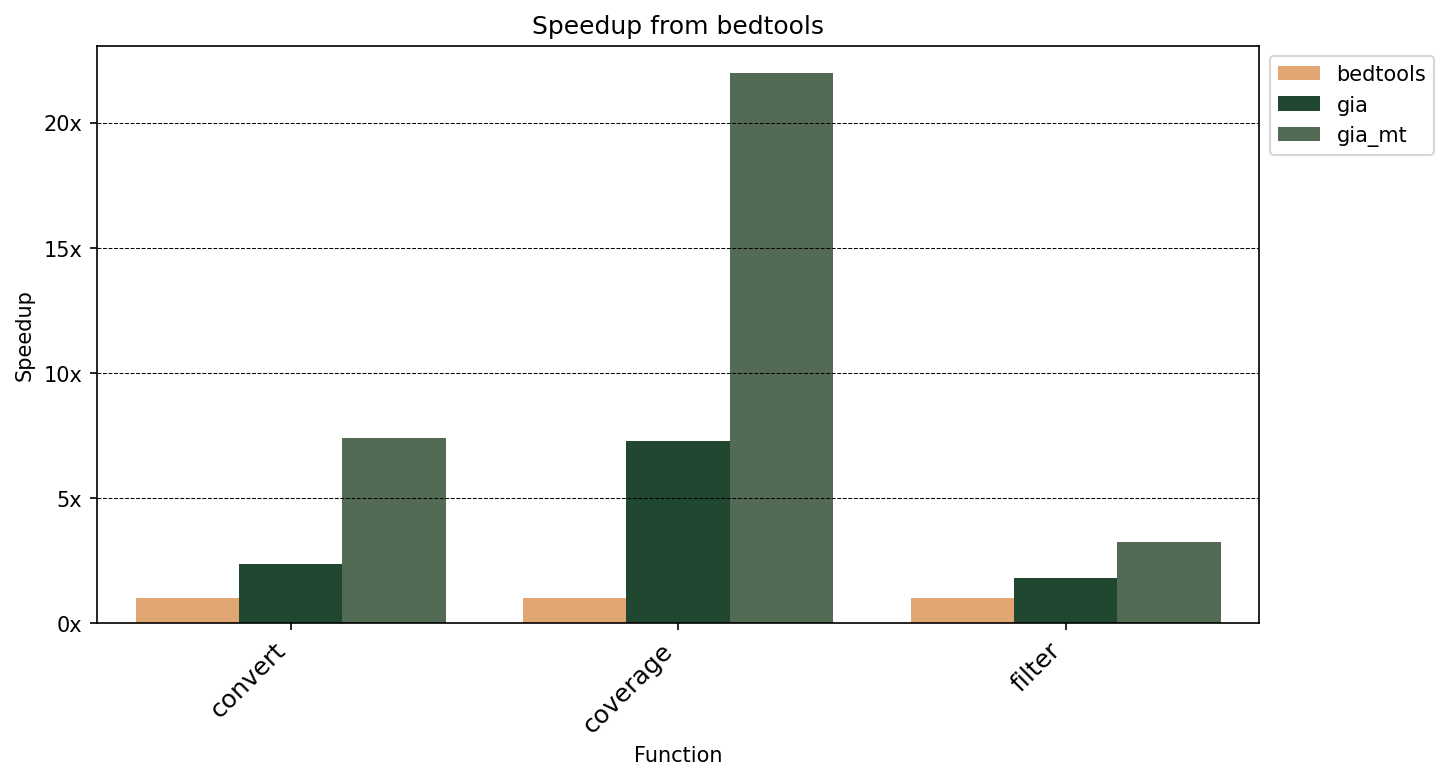

In [4]:
bam = frame[
    (frame["function"].str.contains("bam"))
].sort_values("function")
bam["tool_mt"] = bam["tool"] + bam["multithreaded"].map({True: "_mt", False: ""})
bam_hue_order = ["bedtools", "gia", "gia_mt"]
bam["function"] = bam["function"].str.replace("bam ", "")

plt.figure(figsize=(10, 5), dpi=150)
sns.barplot(
    data=bam,
    x="function",
    y="mean",
    hue="tool_mt",
    hue_order=bam_hue_order,
    palette=hue_colors,
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Mean time (s)")
plt.xlabel("Function")
plt.title("Mean time per BAM function")
plt.yscale("log", base=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# shows grid on y axis
plt.grid(axis='y', linestyle='--', linewidth=0.5, color="black")
plt.show()

bam_speed = bam \
    [bam["tool"].eq("bedtools")] \
    .groupby("function") \
    .agg({"mean": "first"}) \
    .rename(columns={"mean": "base_time"}) \
    .reset_index()
bam_speed = bam.merge(bam_speed, on="function", how="left") \
    .assign(speedup=lambda x: x["base_time"] / x["mean"]) \
    .sort_values("speedup")

plt.figure(figsize=(10, 5), dpi=150)
sns.barplot(
    data=bam_speed,
    x="function",
    y="speedup",
    hue="tool_mt",
    hue_order=bam_hue_order,
    palette=hue_colors,
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}x"))
plt.ylabel("Speedup")
plt.xlabel("Function")
plt.title("Speedup from bedtools")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# shows grid on y axis
plt.grid(axis='y', linestyle='--', linewidth=0.5, color="black")
plt.show()

# Stranded Operations

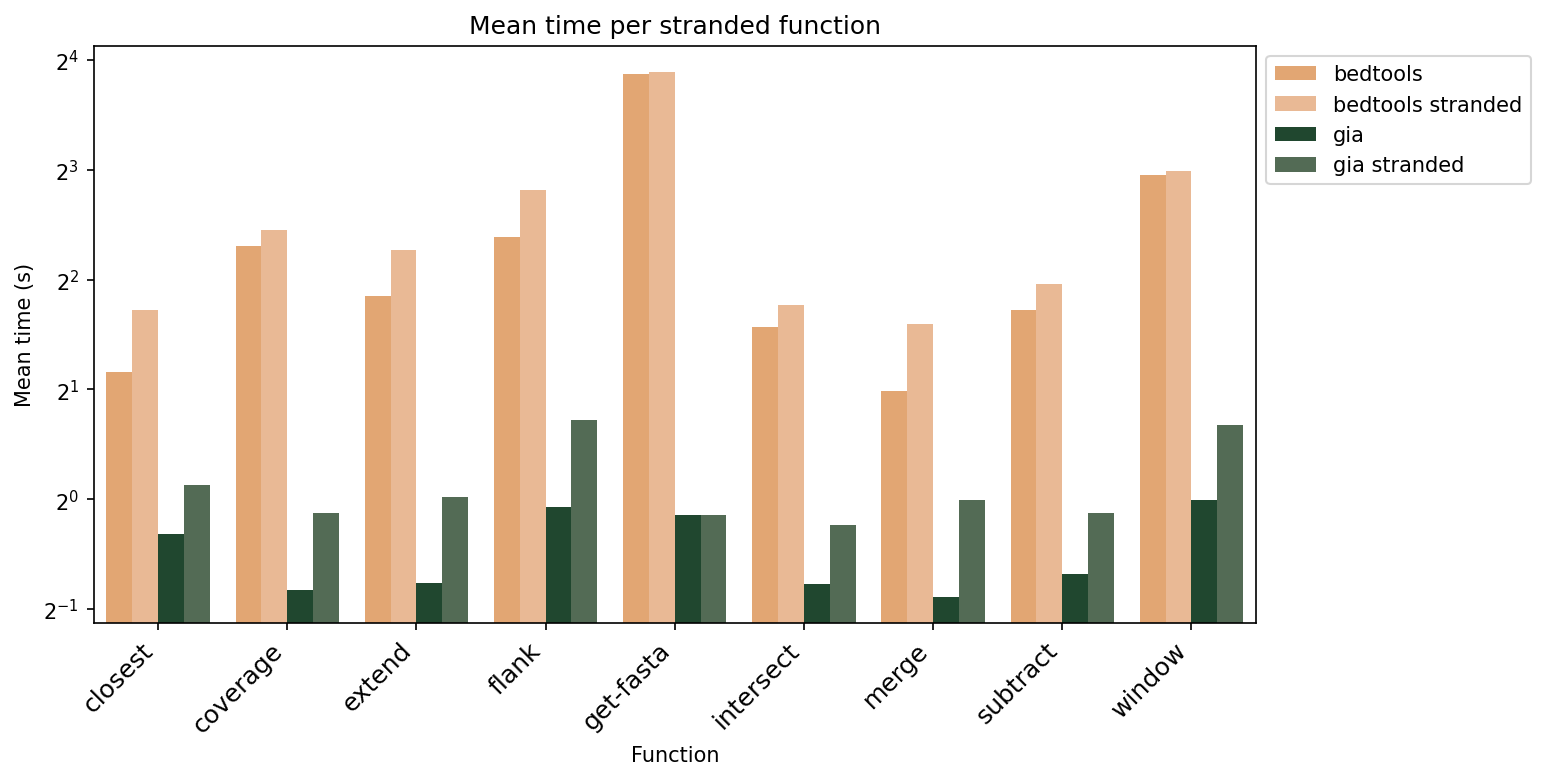

In [5]:
stranded_functions = frame[frame["stranded"]]["function"].values
stranded = frame[
    (frame["function"].isin(stranded_functions)) &
    (~frame["streamed"]) &
    (frame["tool"].ne("bedops")) &
    (~frame["command"].str.contains("gz"))
].copy()
stranded["tool"] = stranded["tool"] + stranded["stranded"].map({True: " stranded", False: ""})
stranded_hue_order = ["bedtools", "bedtools stranded", "gia", "gia stranded"]
stranded = stranded.sort_values(["tool", "function"])

plt.figure(figsize=(10, 5), dpi=150)
ax = sns.barplot(
    data=stranded,
    x="function",
    y="mean",
    hue="tool",
    hue_order=stranded_hue_order,
    palette=hue_colors,
)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Mean time (s)")
plt.xlabel("Function")
plt.title("Mean time per stranded function")
plt.yscale("log", base=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))